In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets
!pip install pytorch_lightning
!huggingface-cli login

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


<h1>IMPORTS</h1>

In [ ]:
from datasets import load_dataset
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import math
import json
import random
from typing import Any, List, Tuple
from transformers import VisionEncoderDecoderConfig
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR
import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only
from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig
from torch.utils.data import DataLoader

<h1>Data Exploration</h1>


In [ ]:
dataset = load_dataset("nielsr/docvqa_1200_examples_donut")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'query', 'answers', 'words', 'bounding_boxes', 'answer', 'ground_truth'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'image', 'query', 'answers', 'words', 'bounding_boxes', 'answer', 'ground_truth'],
        num_rows: 200
    })
})

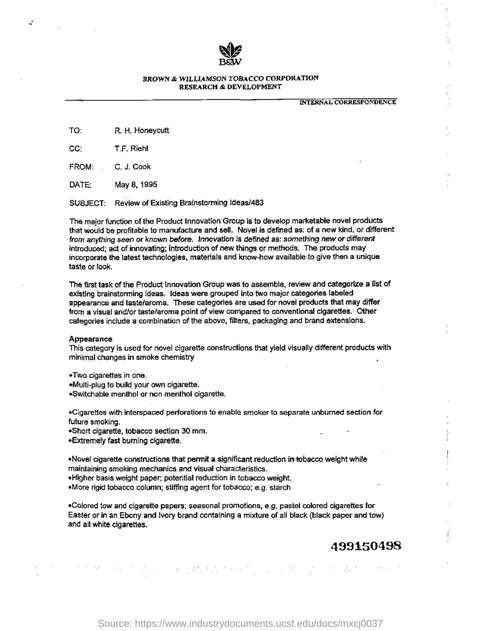

In [ ]:
example = dataset['train'][1]
image = example['image']
width, height = image.size
image.resize((int(width*0.3), int(height*0.3)))

In [ ]:
example['query']

{'de': 'Wer ist in diesem Brief?',
 'en': 'Who is in  cc in this letter?',
 'es': '¿Quién está en cc en esta carta?',
 'fr': 'Qui est dans cette lettre?',
 'it': "Chi c'è in questa lettera?"}

In [ ]:
example['answers']

['T.F. Riehl']

<h1>Prepare needed configurations, processor and the Donut model</h1>

In [ ]:
max_length = 128
image_size = [1280, 960]
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = image_size
config.decoder.max_length = max_length

In [ ]:
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
processor.feature_extractor.size = image_size[::-1]
processor.feature_extractor.do_align_long_axis = False
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base", config=config)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [ ]:
added_tokens = []
class DonutDataset(Dataset):
    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"
            return obj

    def add_tokens(self, list_of_tokens: List[str]):
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)

    def __len__(self) -> int:
        return self.dataset_length - 1

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        sample = self.dataset[idx]
        pixel_values = processor(sample["image"].convert("RGB"), random_padding=self.split == "train", return_tensors="pt").pixel_values
        input_tensor = pixel_values.squeeze()
        processed_parse = random.choice(self.gt_token_sequences[idx])
        input_ids = processor.tokenizer(
            processed_parse,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        if self.split == "train":
            labels = input_ids.clone()
            labels[
                labels == processor.tokenizer.pad_token_id
            ] = self.ignore_id
            labels[
                : torch.nonzero(labels == self.prompt_end_token_id).sum() + 1
            ] = self.ignore_id
            return input_tensor, input_ids, labels
        else:
            prompt_end_index = torch.nonzero(
                input_ids == self.prompt_end_token_id
            ).sum()
            return input_tensor, input_ids, prompt_end_index, processed_parse

<h1>Load Dataset</h1>

In [ ]:
train_dataset = DonutDataset("nielsr/docvqa_1200_examples_donut", max_length=max_length,
                             split="train", task_start_token="<s_docvqa>", prompt_end_token="<s_answer>",
                             sort_json_key=False,
                             )

val_dataset = DonutDataset("nielsr/docvqa_1200_examples_donut", max_length=max_length,
                             split="test", task_start_token="<s_docvqa>", prompt_end_token="<s_answer>",
                             sort_json_key=False,
                             )

/usr/local/lib/python3.10/dist-packages/transformers/models/donut/processing_donut.py:190: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


<h1>Prepare Data Loader</h1>

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class DonutModel(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, decoder_input_ids, labels = batch

        outputs = self.model(pixel_values,
                             decoder_input_ids=decoder_input_ids[:, :-1],
                             labels=labels[:, 1:])
        loss = outputs.loss
        self.log_dict({"train_loss": loss}, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, decoder_input_ids, prompt_end_idxs, answers = batch
        decoder_prompts = pad_sequence(
            [input_id[: end_idx + 1] for input_id, end_idx in zip(decoder_input_ids, prompt_end_idxs)],
            batch_first=True,
        )

        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_prompts,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)

        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = list()
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        return scores


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

<h1>Prepare the necessary training configurations</h1>

In [ ]:
config = {"max_epochs":30,
          "val_check_interval":0.2,
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 800,
          "lr":3e-5,
          "train_batch_sizes": [8],
          "val_batch_sizes": [1],
          "num_nodes": 1,
          "warmup_steps": 300,
          "result_path": "./result",
          "verbose": True,
          }

model_module = DonutModel(config, processor, model)

In [ ]:

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16,
        num_sanity_val_steps=0,
        logger=None,
)

trainer.fit(model_module)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:558: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params
----------------------------------------------------
0 | model | VisionEncoderDecoderModel | 201 M 
----------------------------------------------------
201 M     Trainable params
0         Non-trainable para

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:434: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Prediction: What the location address of NSDA?</s_question><s_answer>between two sandwiches</s_answer>
    Answer: What the location address of NSDA?</s_question><s_answer>1128 SIXTEENTH ST., N. W., WASHINGTON, D. C. 20036</s_answer>
 Normed ED: 0.4067796610169492
Prediction: According to budget request summary what is total amount of other expenses??</s_question><s_answer>A.</s_answer>
    Answer: According to budget request summary what is total amount of other expenses??</s_question><s_answer>$975.00</s_answer>
 Normed ED: 0.05128205128205128
Prediction: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>11:39 a.m</s_answer>
    Answer: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>TRRF Vice President</s_answer>
 Normed ED: 0.17647058823529413
Prediction: How many nomination committee meetings has Y. C. Deveshwar attended?</s_question><s_answer>3</s_answer>
    Answer: How many nomination committee meetings has Y. C. Deveshwar attended?

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: What the location address of NSDA?</s_question><s_answer>The best thing</s_answer>
    Answer: What the location address of NSDA?</s_question><s_answer>1128 sixteenth st., N. W., washington, D. C. 20036</s_answer>
 Normed ED: 0.3474576271186441
Prediction: According to budget request summary what is total amount of other expenses??</s_question><s_answer>$</s_answer>
    Answer: According to budget request summary what is total amount of other expenses??</s_question><s_answer>$975.00</s_answer>
 Normed ED: 0.05128205128205128
Prediction: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>11:39 a.m</s_answer>
    Answer: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>TRRF Vice President</s_answer>
 Normed ED: 0.17647058823529413
Prediction: How many nomination committee meetings has Y. C. Deveshwar attended?</s_question><s_answer>S.</s_answer>
    Answer: How many nomination committee meetings has Y. C. Deveshwar attended?</s_ques

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: What the location address of NSDA?</s_question><s_answer>The best thing</s_answer>
    Answer: What the location address of NSDA?</s_question><s_answer>1128 SIXTEENTH ST., N. W., WASHINGTON, D. C. 20036</s_answer>
 Normed ED: 0.3983050847457627
Prediction: According to budget request summary what is total amount of other expenses??</s_question><s_answer>$ 15,000.00 $ $15,000.00</s_answer>
    Answer: According to budget request summary what is total amount of other expenses??</s_question><s_answer>975.00</s_answer>
 Normed ED: 0.14925373134328357
Prediction: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>11:34 a.m</s_answer>
    Answer: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>lee a. waller</s_answer>
 Normed ED: 0.11458333333333333
Prediction: How many nomination committee meetings has Y. C. Deveshwar attended?</s_question><s_answer>Augusta</s_answer>
    Answer: How many nomination committee meetings has Y. C. Devesh

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: What the location address of NSDA?</s_question><s_answer>The best thing</s_answer>
    Answer: What the location address of NSDA?</s_question><s_answer>1128 SIXTEENTH ST., N. W., WASHINGTON, D. C. 20036</s_answer>
 Normed ED: 0.3983050847457627
Prediction: According to budget request summary what is total amount of other expenses??</s_question><s_answer>975.00</s_answer>
    Answer: According to budget request summary what is total amount of other expenses??</s_question><s_answer>$975.00</s_answer>
 Normed ED: 0.008547008547008548
Prediction: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>12:58 p.m</s_answer>
    Answer: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>TRRF Vice President</s_answer>
 Normed ED: 0.17647058823529413
Prediction: How many nomination committee meetings has Y. C. Deveshwar attended?</s_question><s_answer>3</s_answer>
    Answer: How many nomination committee meetings has Y. C. Deveshwar attended?</s

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: What the location address of NSDA?</s_question><s_answer>The best thing</s_answer>
    Answer: What the location address of NSDA?</s_question><s_answer>1128 sixteenth st., N. W., washington, D. C. 20036</s_answer>
 Normed ED: 0.3474576271186441
Prediction: According to budget request summary what is total amount of other expenses??</s_question><s_answer>$1,228.00</s_answer>
    Answer: According to budget request summary what is total amount of other expenses??</s_question><s_answer>975.00</s_answer>
 Normed ED: 0.05042016806722689
Prediction: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>11:39 a.m</s_answer>
    Answer: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>TRRF Vice President</s_answer>
 Normed ED: 0.17647058823529413
Prediction: How many nomination committee meetings has Y. C. Deveshwar attended?</s_question><s_answer>S.H.M.K.M.</s_answer>
    Answer: How many nomination committee meetings has Y. C. Deveshwar at

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: What the location address of NSDA?</s_question><s_answer>NATIONAL SOFT DRINK A550CLATION NSDA</s_answer>
    Answer: What the location address of NSDA?</s_question><s_answer>1128 SIXTEENTH ST., N. W., WASHINGTON, D. C. 20036</s_answer>
 Normed ED: 0.3474576271186441
Prediction: According to budget request summary what is total amount of other expenses??</s_question><s_answer>$15,000.00</s_answer>
    Answer: According to budget request summary what is total amount of other expenses??</s_question><s_answer>975.00</s_answer>
 Normed ED: 0.05
Prediction: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>TRRF Vice President</s_answer>
    Answer: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>TRRF Vice President</s_answer>
 Normed ED: 0.0
Prediction: How many nomination committee meetings has Y. C. Deveshwar attended?</s_question><s_answer>Dr.K.</s_answer>
    Answer: How many nomination committee meetings has Y. C. Deveshwar atten

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: What the location address of NSDA?</s_question><s_answer>The best thing between two sandwiches.</s_answer>
    Answer: What the location address of NSDA?</s_question><s_answer>1128 sixteenth st., N. W., washington, D. C. 20036</s_answer>
 Normed ED: 0.3389830508474576
Prediction: According to budget request summary what is total amount of other expenses??</s_question><s_answer>$ 15,000,000</s_answer>
    Answer: According to budget request summary what is total amount of other expenses??</s_question><s_answer>$975.00</s_answer>
 Normed ED: 0.06557377049180328
Prediction: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>11:39 a.m.</s_answer>
    Answer: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>lee a. waller</s_answer>
 Normed ED: 0.11458333333333333
Prediction: How many nomination committee meetings has Y. C. Deveshwar attended?</s_question><s_answer>American at Nominations committee Meetings</s_answer>
    Answer: How ma

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: What the location address of NSDA?</s_question><s_answer>The best thing</s_answer>
    Answer: What the location address of NSDA?</s_question><s_answer>1128 sixteenth st., N. W., washington, D. C. 20036</s_answer>
 Normed ED: 0.3474576271186441
Prediction: According to budget request summary what is total amount of other expenses??</s_question><s_answer>19</s_answer>
    Answer: According to budget request summary what is total amount of other expenses??</s_question><s_answer>975.00</s_answer>
 Normed ED: 0.05172413793103448
Prediction: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>Vice President</s_answer>
    Answer: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>TRRF Vice President</s_answer>
 Normed ED: 0.049019607843137254
Prediction: How many nomination committee meetings has Y. C. Deveshwar attended?</s_question><s_answer>Washington</s_answer>
    Answer: How many nomination committee meetings has Y. C. Deveshwar att

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: What the location address of NSDA?</s_question><s_answer>The best thing</s_answer>
    Answer: What the location address of NSDA?</s_question><s_answer>1128 sixteenth st., N. W., washington, D. C. 20036</s_answer>
 Normed ED: 0.3474576271186441
Prediction: According to budget request summary what is total amount of other expenses??</s_question><s_answer>$</s_answer>
    Answer: According to budget request summary what is total amount of other expenses??</s_question><s_answer>975.00</s_answer>
 Normed ED: 0.05172413793103448
Prediction: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>11:44</s_answer>
    Answer: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>TRRF Vice President</s_answer>
 Normed ED: 0.18627450980392157
Prediction: How many nomination committee meetings has Y. C. Deveshwar attended?</s_question><s_answer>3</s_answer>
    Answer: How many nomination committee meetings has Y. C. Deveshwar attended?</s_question><

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: What the location address of NSDA?</s_question><s_answer>The best thing</s_answer>
    Answer: What the location address of NSDA?</s_question><s_answer>1128 sixteenth st., N. W., washington, D. C. 20036</s_answer>
 Normed ED: 0.3474576271186441
Prediction: According to budget request summary what is total amount of other expenses??</s_question><s_answer>5,130,67</s_answer>
    Answer: According to budget request summary what is total amount of other expenses??</s_question><s_answer>975.00</s_answer>
 Normed ED: 0.059322033898305086
Prediction: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>TriRF Vice President</s_answer>
    Answer: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>lee a. waller</s_answer>
 Normed ED: 0.1650485436893204
Prediction: How many nomination committee meetings has Y. C. Deveshwar attended?</s_question><s_answer>2</s_answer>
    Answer: How many nomination committee meetings has Y. C. Deveshwar attende

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: What the location address of NSDA?</s_question><s_answer>The best thing</s_answer>
    Answer: What the location address of NSDA?</s_question><s_answer>1128 SIXTEENTH ST., N. W., WASHINGTON, D. C. 20036</s_answer>
 Normed ED: 0.3983050847457627
Prediction: According to budget request summary what is total amount of other expenses??</s_question><s_answer>$ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $ $
    Answer: According to budget request summary what is total amount of other expenses??</s_question><s_answer>975.00</s_answer>
 Normed ED: 0.6806451612903226
Prediction: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>11:39 a.m</s_answer>
    Answer: Who is ‘presiding’ TRRF GENERAL SESSION (PART 1)?</s_question><s_answer>lee a. waller</s_answer>
 Normed ED: 0.11458333333333333
Prediction: Ho